In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('text', usetex=True)
plt.rc('font', size=12)
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

### Implementação do Diagrama de Voronoi

In [2]:
import numpy as np

class VoronoiDiagram:
    def __init__(self, data):
        # Initialize the Voronoi diagram with input data
        self.data = np.array(data)
        self.cells = []

    def search_for_cell(self, point):
        # Search for the cell that contains the given point
        dist = float("inf")
        for i, cell in enumerate(self.cells):
            aux = np.sqrt((point[0] - cell[0][0])**2 + (point[1] - cell[0][1])**2)
            if aux < dist:
                dist = aux
                pos = i
        return pos

    def search_for_cell_by_edge(self, edge_ref, origin_cell):
        # Search for the cell containing a given edge reference and originating cell
        precision = 0.8
        for i, cell in enumerate(self.cells):
            for j, edge in enumerate(cell[1]):
                if i != origin_cell:
                    if (
                        abs(edge[0][0] - edge_ref[0][0]) <= precision
                        and abs(edge[0][1] - edge_ref[0][1]) <= precision
                        and abs(edge[1][0] - edge_ref[1][0]) <= precision
                        and abs(edge[1][1] - edge_ref[1][1]) <= precision
                    ):
                        output = i

                    if (
                        abs(edge[1][0] - edge_ref[0][0]) <= precision
                        and abs(edge[1][1] - edge_ref[0][1]) <= precision
                        and abs(edge[0][0] - edge_ref[1][0]) <= precision
                        and abs(edge[0][1] - edge_ref[1][1]) <= precision
                    ):
                        output = i
        return output

    def adapt_cell(self, visited_cell, edge_added, point_added):
        # Adapt the cell based on the visited cell, added edge, and added point
        drop = []
        for i, edge in enumerate(self.cells[visited_cell][1]):
            A = edge[0]
            B = edge[1]
            C = edge_added[0]
            D_0 = round(A[0] * B[1] + A[1] * C[0] + B[0] * C[1] - C[0] * B[1] - A[0] * C[1] - A[1] * B[0], 4)
            C = edge_added[1]
            D_1 = round(A[0] * B[1] + A[1] * C[0] + B[0] * C[1] - C[0] * B[1] - A[0] * C[1] - A[1] * B[0], 4)

            # Determine precision based on the magnitude of D
            if max(abs(D_0), abs(D_1)) >= 2000000:
                precision = 1.5
            elif max(abs(D_0), abs(D_1)) < 2000000 and max(abs(D_0), abs(D_1)) > 50000:
                precision = 0.8
            elif max(abs(D_0), abs(D_1)) <= 50000 and max(abs(D_0), abs(D_1)) > 1000:
                precision = 0.5
            elif max(abs(D_0), abs(D_1)) <= 1000:
                precision = 0.01

            if abs(D_0) <= precision or abs(D_1) <= precision:
                if abs(D_0) <= precision:
                    p = edge_added[0]
                else:
                    p = edge_added[1]

                dist_1 = np.sqrt((point_added[0] - A[0]) ** 2 + (point_added[1] - A[1]) ** 2)
                dist_2 = np.sqrt((self.cells[visited_cell][0][0] - A[0]) ** 2 + (self.cells[visited_cell][0][1] - A[1]) ** 2)

                if dist_1 < dist_2:
                    self.cells[visited_cell][1][i][0] = [p[0], p[1], 1][:]
                else:
                    self.cells[visited_cell][1][i][1] = [p[0], p[1], 1][:]

            if abs(D_0) > precision and abs(D_1) > precision:
                dist_1 = np.sqrt((point_added[0] - A[0]) ** 2 + (point_added[1] - A[1]) ** 2)
                dist_2 = np.sqrt((self.cells[visited_cell][0][0] - A[0]) ** 2 + (self.cells[visited_cell][0][1] - A[1]) ** 2)

                if dist_1 < dist_2:
                    drop.append(edge)

        self.cells[visited_cell][1].append(edge_added[:])

        for element in drop:
            self.cells[visited_cell][1].remove(element)

    def make_edge(self, cell, p):
        # Make an edge for the given cell and point
        C = self.cells[cell][0]
        M = [round((C[0] + p[0]) / 2, 4), round((C[1] + p[1]) / 2, 4)]
        V_1 = [C[0] - M[0], C[1] - M[1]]
        if V_1[1] == 0:
            V_2 = [0, 1]
        else:
            V_2 = [1, -V_1[0] / V_1[1]]
        output, NEIGHBOURS = [], []

        for edge in self.cells[cell][1]:
            A = edge[0]
            B = edge[1]

            if A[0] == B[0]:
                A[0] = A[0] + 0.1
                B[0] = B[0] - 0.1

            if A[1] == B[1]:
                A[1] = A[1] + 0.1
                B[1] = B[1] - 0.1

            V_3 = [B[0] - A[0], B[1] - A[1]]
            D = round((-V_3[0] * V_2[1] + V_3[1] * V_2[0]), 4)

            if abs(D) > 0.1:
                D_t = (M[1] - A[1]) * V_3[0] - (M[0] - A[0]) * V_3[1]
                t = D_t / D
                INTERSECT = [round(M[0] + t * V_2[0], 4), round(M[1] + t * V_2[1], 4), 1]
                IS_VALID = False

                if A[2] == 1 and B[2] == 1:
                    if INTERSECT[0] < max(A[0], B[0]) and INTERSECT[0] > min(A[0], B[0]):
                        IS_VALID = True

                if A[2] == 0 and B[2] == 1:
                    if A[0] > B[0] and INTERSECT[0] > B[0]:
                        IS_VALID = True
                    if A[0] < B[0] and INTERSECT[0] < B[0]:
                        IS_VALID = True

                if A[2] == 1 and B[2] == 0:
                    if A[0] > B[0] and INTERSECT[0] < A[0]:
                        IS_VALID = True
                    if A[0] < B[0] and INTERSECT[0] > A[0]:
                        IS_VALID = True

                if A[2] == 0 and B[2] == 0:
                    IS_VALID = True

                if IS_VALID:
                    T = t
                    output.append(INTERSECT)
                    NEIGHBOURS.append(self.search_for_cell_by_edge(edge, cell))

        if len(output) == 1:
            if self.search_for_cell(M) == cell:
                inf_point = [round(M[0] - 10 * T * V_2[0], 4), round(M[1] - 10 * T * V_2[1], 4), 0]
                i = 2
                while np.sqrt((self.cells[cell][0][0] - inf_point[0]) ** 2 + (self.cells[cell][0][1] - inf_point[0]) ** 2) < 1000:
                    inf_point = [round(M[0] - i * 10 * T * V_2[0], 4), round(M[1] - i * 10 * T * V_2[1], 4), 0]
                    i += 1

            else:
                inf_point = [round(M[0] + 10 * T * V_2[0], 4), round(M[1] + 10 * T * V_2[1], 4), 0]
                i = 2
                while (
                    np.sqrt((self.cells[cell][0][0] - inf_point[0]) ** 2 + (self.cells[cell][0][1] - inf_point[0]) ** 2)
                    < 1000
                    or self.search_for_cell(inf_point) != cell
                ):
                    inf_point = [round(M[0] + i * 10 * T * V_2[0], 4), round(M[1] + i * 10 * T * V_2[1], 4), 0]
                    i += 1

            output.append(inf_point)

        return output, NEIGHBOURS

    def construct_cell(self, cell, p):
        # Construct a cell for the given cell index and point
        edges, VISITED = [], []
        edge, NEIGHBOURS = self.make_edge(cell, p)
        VISITED.append(cell)
        edges.append(edge)

        for N in NEIGHBOURS:
            NEXT_CELL = N
            if NEXT_CELL not in VISITED:
                FLAG = True
            while FLAG:
                edge, NEIGHBOURS = self.make_edge(NEXT_CELL, p)
                edges.append(edge)
                VISITED.append(NEXT_CELL)
                FLAG = False
                if NEIGHBOURS != []:
                    for NEIGHBOUR in NEIGHBOURS:
                        if NEIGHBOUR not in VISITED:
                            FLAG = True
                            NEXT_CELL = NEIGHBOUR

        for i, VISIT in enumerate(VISITED):
            self.adapt_cell(VISIT, edges[i], p)

        return [p, edges]

    def build_voronoi_diagram(self):
        # Build the Voronoi diagram based on the input data
        mid = [(self.data[1][0] + self.data[0][0]) / 2, (self.data[1][1] + self.data[0][1]) / 2]
        V = [self.data[0][0] - mid[0], self.data[0][1] - mid[1]]
        self.cells.append(
            [
                self.data[0],
                [
                    [
                        [round(mid[0] + 1000, 4), round(mid[1] - (V[0] / V[1]) * 1000, 4), 0],
                        [round(mid[0] - 1000, 4), round(mid[1] + (V[0] / V[1]) * 1000, 4), 0],
                    ]
                ],
            ]
        )
        self.cells.append(
            [
                self.data[1],
                [
                    [
                        [round(mid[0] + 1000, 4), round(mid[1] - (V[0] / V[1]) * 1000, 4), 0],
                        [round(mid[0] - 1000, 4), round(mid[1] + (V[0] / V[1]) * 1000, 4), 0],
                    ]
                ],
            ]
        )

        for i in range(2, len(self.data)):
            cell = self.search_for_cell(self.data[i])
            self.cells.append(self.construct_cell(cell, self.data[i]))

        return self.cells

In [3]:
def plot_voronoi(data, cells):
        fig, ax = plt.subplots(figsize = (6, 6))
        ax.scatter(data[:, 0], data[:, 1], color='navy', label = 'Pontos')
        axes = plt.axis()
        
        for c in cells:
            for line in c[1]:
                plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], linewidth = 1, color = "black")
                
        plt.xlim([axes[0], axes[1]])
        plt.ylim([axes[2], axes[3]])

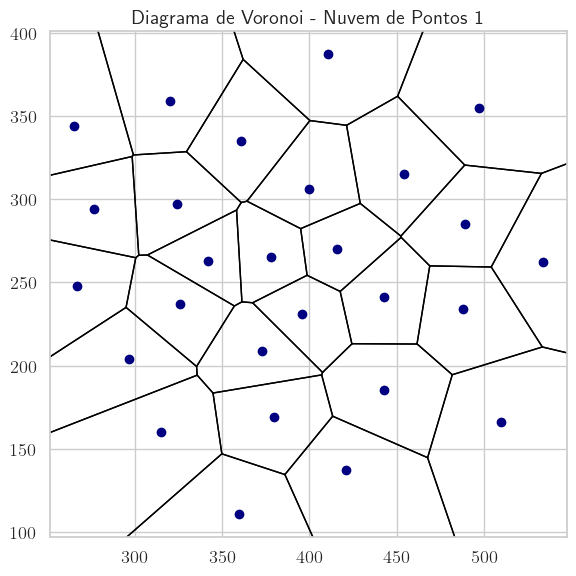

In [ ]:
points = np.loadtxt("nuvem1.txt")
vor = VoronoiDiagram(points).build_voronoi_diagram()
plot_voronoi(points, vor)
plt.title("Diagrama de Voronoi - Nuvem de Pontos 1")
plt.tight_layout()
plt.savefig("plot_voronoi1.pdf")
plt.show()

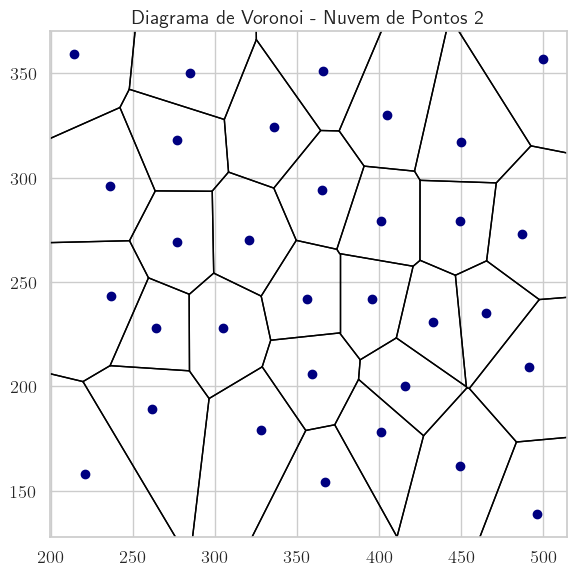

In [ ]:
points = np.loadtxt("nuvem2.txt")
vor = VoronoiDiagram(points).build_voronoi_diagram()
plot_voronoi(points, vor)
plt.title("Diagrama de Voronoi - Nuvem de Pontos 2")
plt.tight_layout()
plt.savefig("plot_voronoi2.pdf")
plt.show()